In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [7]:
df = pd.read_csv('/content/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [8]:
# drop unnnamed columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# rename the columns
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# convert the labels to binary
df['b_labels'] = df['labels'].map({'ham':0, 'spam':1})

# set it to the y as a matrix/array
y = df['b_labels'].values

In [11]:
# split into test train
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size = 0.33, random_state = 1)

In [12]:
# convert sentences to sequences
max_vocab_size = 20000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
sequences_train = tokenizer.texts_to_sequences(x_train)
sequences_test = tokenizer.texts_to_sequences(x_test)

In [13]:
# take a look at the encoding
print(x_train[0])
print(sequences_train[0])

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
[423, 25, 1, 286, 3, 210, 5, 3468]


In [14]:
# check the length
# they are variable so will need some padding
print(len(sequences_test[0]))
print(len(sequences_test[1]))

5
8


In [15]:
# check the word index mapping (to check the number of words in the vocabulary)
word2idx = tokenizer.word_index
V = len(word2idx)
print('Total number of unique words are : %s' % V)

Total number of unique words are : 7245


In [16]:
# pad the sequences to get N X T matrix
# need to set a max size
data_train = pad_sequences(sequences_train)
print('The Shape of the train data tensor: ', data_train.shape)

The Shape of the train data tensor:  (3733, 189)


In [17]:
# find the largest size first
# this will be used to set max and pad
T = data_train.shape[1]
T

189

In [18]:
# pad the test set with T as the max
data_test = pad_sequences(sequences_test, maxlen=T)
# this will truncate any longer sentences
print('Shape of the test data tensor: ', data_test.shape)

Shape of the test data tensor:  (1839, 189)


# Build the RNN Model

In [25]:
# create the model

# set a hyperparameter, can choose any word vector size
# this is the embedding dimensionality
D = 20


# hidden state vectorsize
M = 15

# input later must reflect the max length T
i = Input(shape=(T,))

# embedding layer
# take in a sequence of integers and return sequences of word vectors
# this will be an N * T * D array
# output is D
# we want the size of the embedding to (V + 1) x D because the first word index starts from 1 and not 0
x = Embedding(V+1, D)(i)


# LSTM layer
x = LSTM(M, return_sequences = True)(x)
x = GlobalMaxPooling1D()(x)

# Dense layer, use sigmoid for binary classification
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 189)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 189, 20)           144920    
_________________________________________________________________
lstm_1 (LSTM)                (None, 189, 15)           2160      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 15)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 16        
Total params: 147,096
Trainable params: 147,096
Non-trainable params: 0
_________________________________________________________________


In [27]:
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# train the model
r = model.fit(x = data_train, y=y_train, epochs=10, validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 10s 67ms/step - loss: 0.5609 - accuracy: 0.7765 - val_loss: 0.3874 - val_accuracy: 0.8690
Epoch 2/10
117/117 [==============================] - 8s 66ms/step - loss: 0.3900 - accuracy: 0.8639 - val_loss: 0.3378 - val_accuracy: 0.8690
Epoch 3/10
117/117 [==============================] - 7s 64ms/step - loss: 0.3240 - accuracy: 0.8713 - val_loss: 0.3132 - val_accuracy: 0.8690
Epoch 4/10
117/117 [==============================] - 7s 64ms/step - loss: 0.3033 - accuracy: 0.8688 - val_loss: 0.2886 - val_accuracy: 0.8690
Epoch 5/10
117/117 [==============================] - 7s 64ms/step - loss: 0.2837 - accuracy: 0.8589 - val_loss: 0.2506 - val_accuracy: 0.8690
Epoch 6/10
117/117 [==============================] - 8s 64ms/step - loss: 0.2396 - accuracy: 0.8582 - val_loss: 0.2139 - val_accuracy: 0.8690
Epoch 7/10
117/117 [==============================] - 7s 64ms/step - loss: 0.1965 - accuracy: 0.8621 - val_loss: 0.1877 - val_accuracy: 0.869

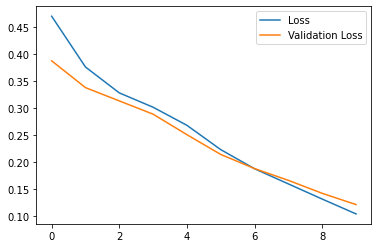

In [29]:
# plot loss per iteration
plt.plot(r.history['loss'], label = 'Loss')
plt.plot(r.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

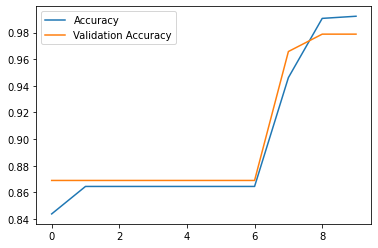

In [30]:
# Accuracy per iteration
# Second CNN layer
plt.plot(r.history['accuracy'], label = 'Accuracy')
plt.plot(r.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.show()